# Plot script for figure 5

In [1]:
import os
import intake
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import easygems.healpix as egh
import healpy 
import pickle

from healpix_plot import default_plot, get_listed_colormap, plot_polygon
from healpix_functions import evaluate_against_coarse_xarray
path = 'data'
figpath = 'figures_paper'

mpl.rc('font', **{'size': 8})
proj = ccrs.Mollweide()
cm = 1/2.54  # centimeters in inches

ERROR 1: PROJ: proj_create_from_database: Open of /home/b/b381815/miniconda3/envs/py/share/proj failed


In [2]:
pr = xr.open_dataset(os.path.join(path, 'ICON-ngc4008', 'z9', 'pr_day_ICON-ngc4008_ssp370_zoom9.nc'))['pr']
pr = pr.sel(time='2025-03-08')

In [3]:
bounds_all = np.arange(0, 1000.01, .01)
bounds_all = np.concatenate([bounds_all, [9999]])  # ensure the last bin covers all the rest

binned = {}
with open('/work/uc1275/LukasBrunner/data/SubGridVariability/results/pr_binned-frequencies_ifs_2021-2049.pkl', 'rb') as ff:
    binned['ifs'] = pickle.load(ff)

with open('/work/uc1275/LukasBrunner/data/SubGridVariability/results/pr_binned-frequencies_icon_2021-2049.pkl', 'rb') as ff:
    binned['icon'] = pickle.load(ff)

zoom_levels = range(4, 10)
colors = mpl.colormaps['viridis'](np.linspace(0, 1, len(zoom_levels)))

zoom_km = {
    10: 6,
    9: 13,
    8: 26,
    7: 51,
    6: 102,
    5: 203,
    4: 407,
    3: 815,
    2: 1630,
    1: 3260,
    0: 6520,
}

text_dict = {
    'B': '(b) ICON',
    'C': '(c) ICON',
    'D': '(d) ICON',
    'E': '(e) IFS',
    'F': '(f) ICON',
    'G': '(g) ICON',
}

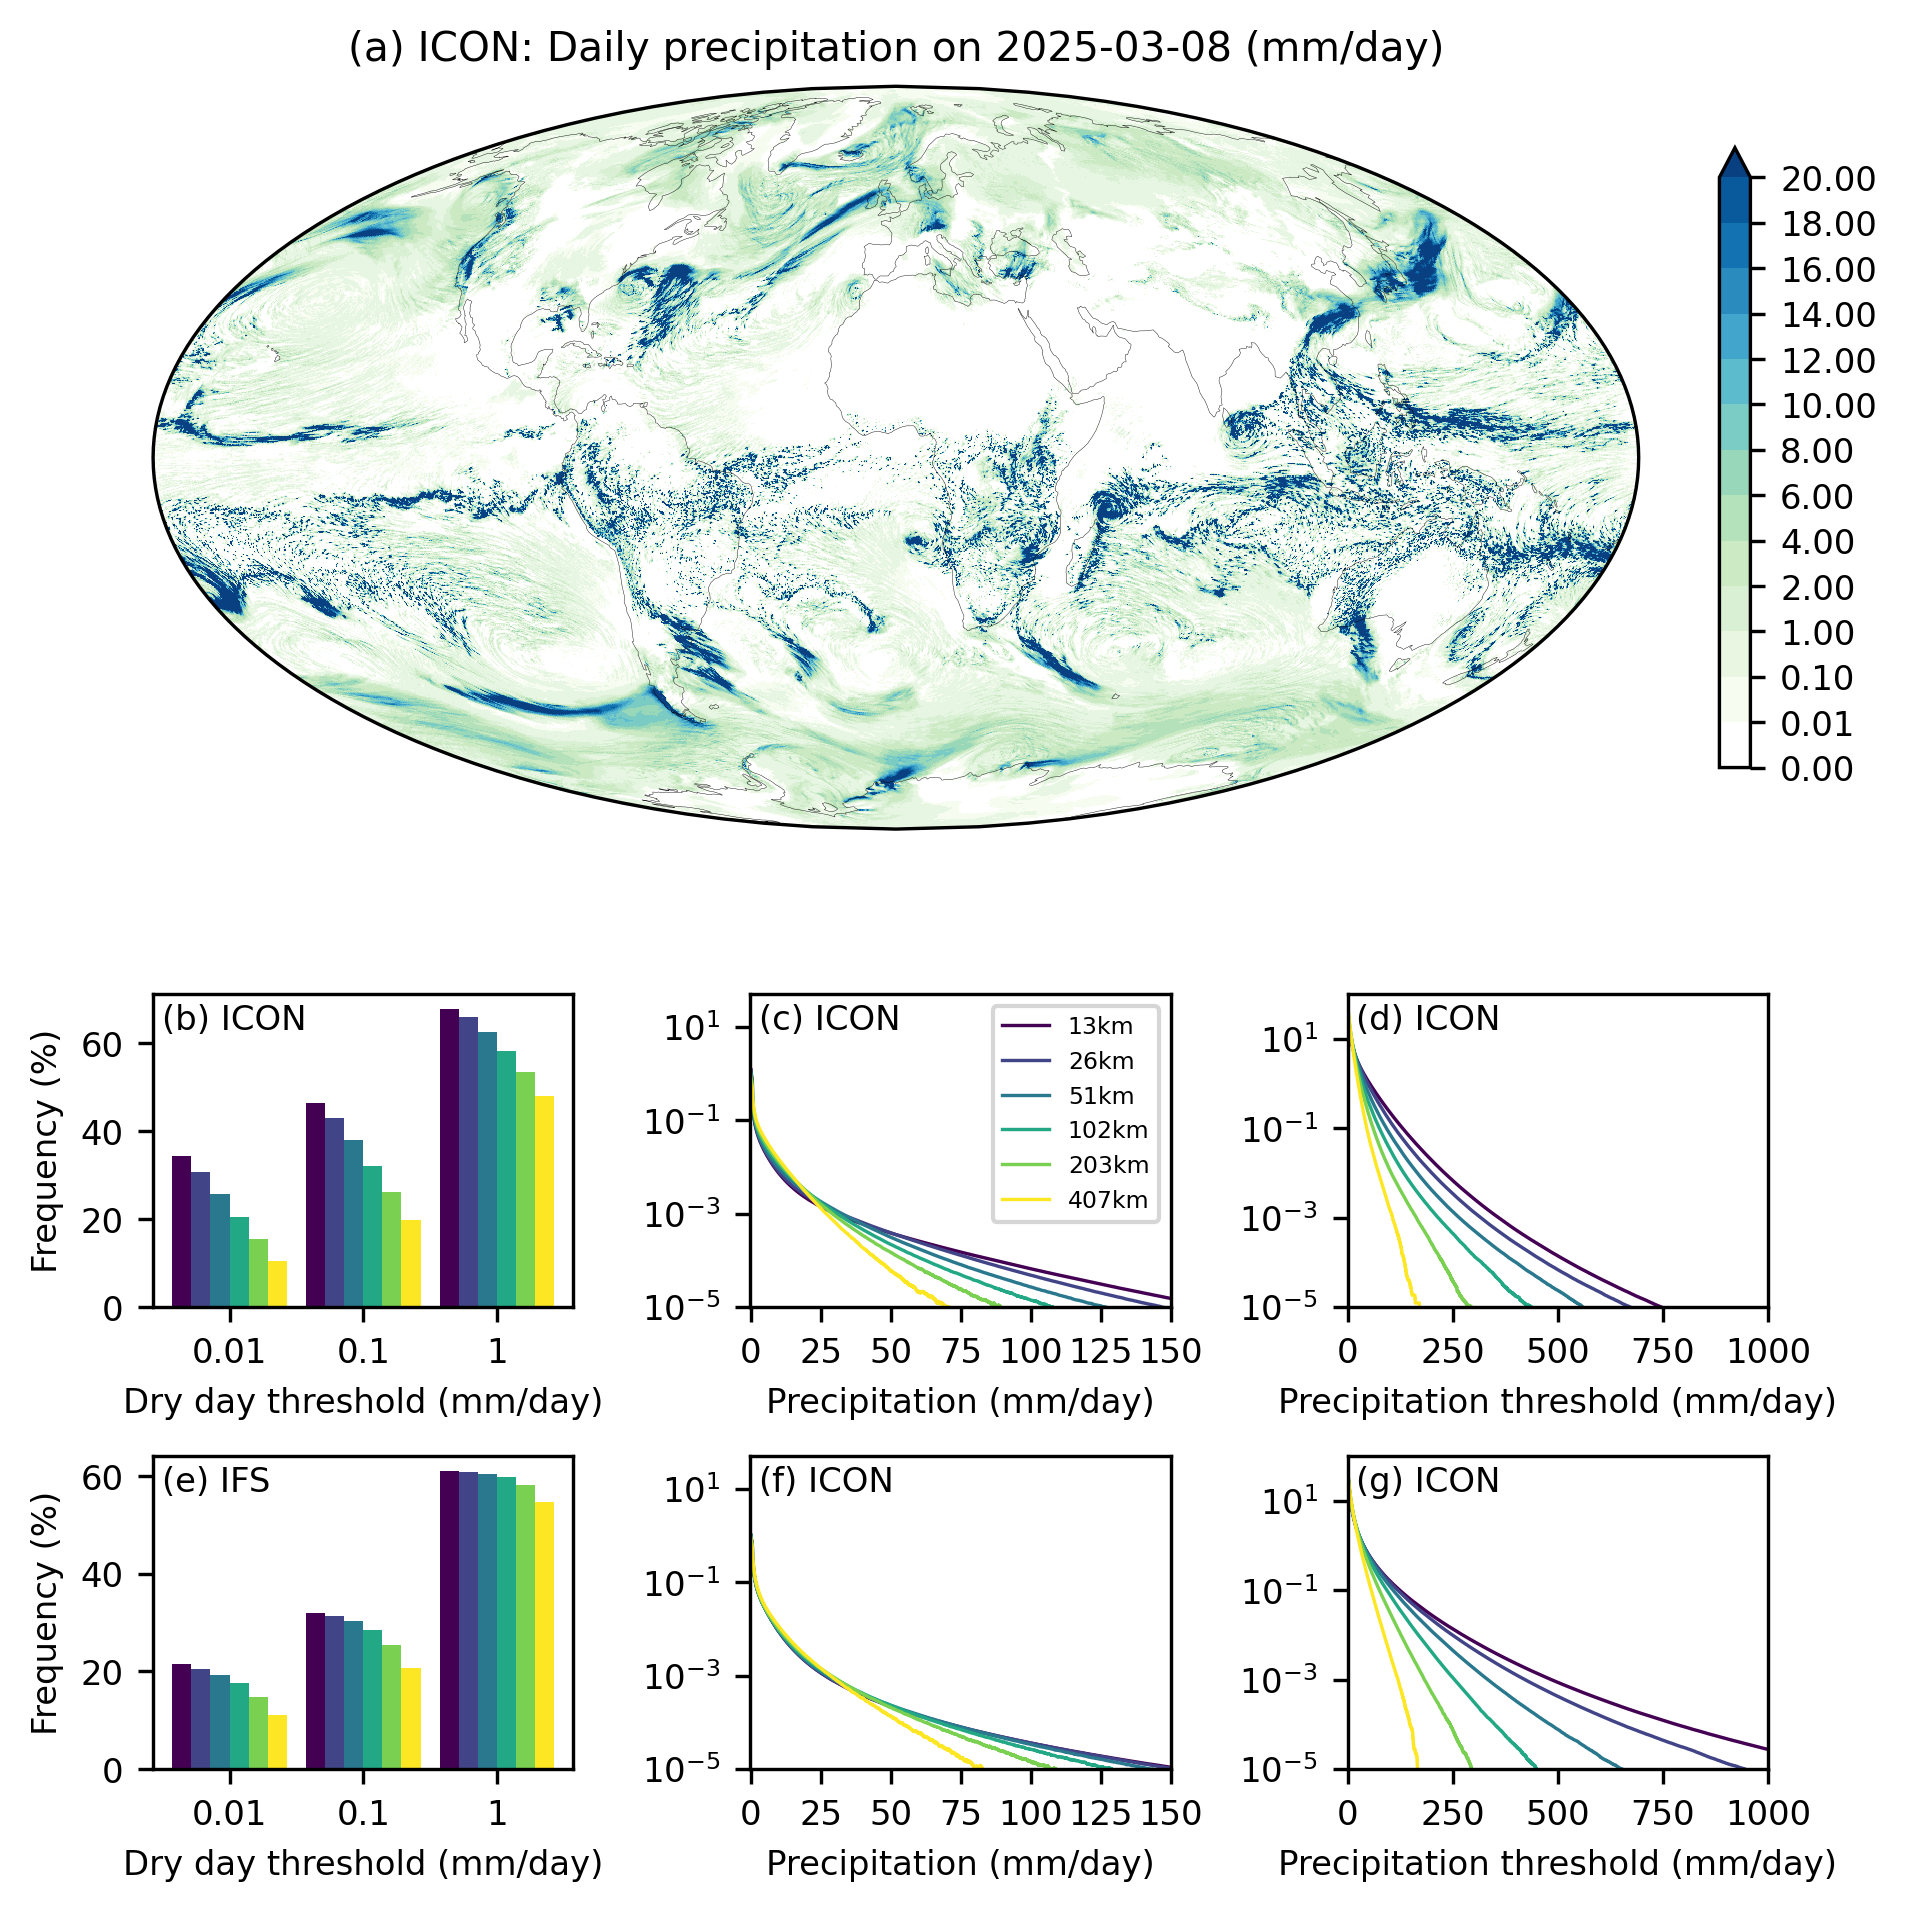

In [4]:
dpi = 305

fig, axes = plt.subplot_mosaic(
    """
    AAAAAA
    AAAAAA
    AAAAAA
    AAAAAA
    BBCCDD
    BBCCDD
    EEFFGG
    EEFFGG
    """,
    figsize=(16*cm, 16*cm),
    dpi=dpi,
    per_subplot_kw={
        'A': {'projection': proj},
    }
)

# --- A: global map of sub-grid anomaly from ICON ---
ax = axes['A']
ax.set_title('(a) ICON: Daily precipitation on 2025-03-08 (mm/day)')
ax.set_global()
levels = [0, .01, .1, 1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
default_plot(
    pr, 
    ax=ax,
    cmap=get_listed_colormap(levels, 'GnBu', return_colors=True, extend='max', white='first'),
    levels=levels,
    extend='max',
)

# --- B, E: dry days ---
dd = len(zoom_levels) + 1
for key, model in zip(['B', 'E'], ['icon', 'ifs']):
    ax = axes[key]
    
    for idx, zoom in enumerate(zoom_levels[::-1]):
        ax.bar(idx, binned[model][zoom][0] * 100, color=colors[idx], width=1)
        ax.bar(idx + dd, binned[model][zoom][:10].sum() * 100,
                color=colors[idx], width=1)
        ax.bar(idx + 2*dd, binned[model][zoom][:100].sum() * 100,
                color=colors[idx], width=1)
    
    ax.set_xticks([(dd - 2) / 2, (dd - 2) / 2 + dd, (dd - 2) / 2 + 2*dd])
    ax.set_xticklabels(['0.01', '0.1', '1'])
    ax.set_xlabel('Dry day threshold (mm/day)')
    ax.set_ylabel('Frequency (%)')
    ax.text(0.02, .97, text_dict[key], ha='left', va='top', transform=ax.transAxes)

# --- C, F: distribution ---
for key, model in zip(['C', 'F'], ['icon', 'ifs']):
    ax = axes[key]
    
    for idx, zoom in enumerate(zoom_levels[::-1]):
        ax.plot(
            bounds_all[1:], 
            xr.DataArray(binned[model][zoom]).rolling({'dim_0': 100}, center=True, min_periods=1).mean() * 100,
            label='{}km'.format(zoom_km[zoom]), 
            color=colors[idx],
            lw=.8,
        )
    
    ax.set_xlim(-.2, 150)
    ax.set_ylim(1e-5, 5e1)
    ax.set_yscale('log')
    
    ax.set_xlabel('Precipitation (mm/day)')
    # ax.set_ylabel('Frequency (%)')
    ax.set_xticks(np.arange(0, 151, 25))
    ax.text(0.02, .97, text_dict[key], ha='left', va='top', transform=ax.transAxes)
    if model == 'icon':
        ax.legend(fontsize='x-small', ncol=1)

# --- D, G: exceedance ---
for key, model in zip(['D', 'G'], ['icon', 'ifs']):
    ax = axes[key]
    
    for idx, zoom in enumerate(zoom_levels[::-1]):
        ax.plot(
            bounds_all[1:], 
            np.cumsum(binned[model][zoom][::-1])[::-1] * 100, 
            color=colors[idx],
            lw=.8,
        )
    
    ax.set_xlim(0, 1000)
    ax.set_ylim(1e-5, 1e2)
    ax.set_yscale('log')
    
    ax.set_xlabel('Precipitation threshold (mm/day)')
    # ax.set_ylabel('Frequency (%)')
    ax.text(0.02, .97, text_dict[key], ha='left', va='top', transform=ax.transAxes)

fig.tight_layout()
fig.savefig(os.path.join(figpath, 'figure1.png'), dpi=dpi)
fig.savefig(os.path.join(figpath, 'figure1.pdf'), dpi=dpi)